# MOVIE RECOMMENDATIONS SYSTEM

**Domain - OTT Platform**

## Context:

Over the past two decades, there has been a monumental shift in how people access and consume video content. With the universal access to broadband internet, numerous platforms like YouTube, Netflix, HBO Go emerged and steadily grew to
prominence. Although not a household name in itself, OTT is the exact technology that made the streaming revolution possible. OTT stands for Over The Top, refers to any video streaming service delivering content to the users over the internet, however there are subscription charges associated with the usage of such platforms such as PrimeVideo, Netflix, HotStar, Zee5, SonyLiv etc. But choosing your next movie to watch can still be a daunting task, even if you have access to all the platforms.


## Business Requirement:

“MyNextMovie” is a budding startup in the space of recommendations on top of various OTT platforms providing suggestions to its customer base regarding their next movie. Their major business is to create a recommendation layer on top of these OTT platforms so that they can make suitable recommendations to their customers, however, since they are in research mode right now, they would want to experiment with open-source data first to understand the depth of the models which can be delivered by them. The data for this exercise is open-source data which has been collected and made available from the MovieLens web site (http://movielens.org), a part of GroupLens Research The data sets were collected over various periods of time, depending on the size of the set. You have recently joined as a Data Scientist at “MyNextMovie” and plan to help the
existing team to set up a recommendation platform

## Data Description:

The data consists of 105339 ratings applied over 10329 movies. The average rating is 3.5 and minimum and maximum rating is 0.5 and 5 respectively. There are 668 users who have given their ratings for 149532 movies. There are two data files which are provided:

**Movies.csv**

- movieId: ID assigned to a movie
- title: Title of a movie
- genres: pipe separated list of movie genres.

**Ratings.csv**

- userId: ID assigned to a user
- movieId: ID assigned to a movie
- rating: rating by a user to a movie
- Timestamp: time at which the rating was provided.

## Objective:

1. Create a popularity based recommender system at a genre level. User will input a genre (g), minimum ratings threshold (t) for a movie and no. of recommendations(N) for which it should be recommended top N movies which are most popular within that genre (g) ordered by ratings in descending order where each movie has at least (t) reviews.
2. Create a content based recommender system which recommends top N movies based on similar movie(m) genres.
3. Create a collaborative based recommender system which recommends top N movies based on “K” s) to play around with the recommendation modules.

## 1. Import libraries & load datasets

----

**Importing required libraries**

In [1]:
import numpy as np
import pandas as pd
from ipywidgets import widgets as wdg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

**Setting default values for graphs**

In [4]:
plt.rcParams['font.size']=10
plt.rcParams['axes.grid']=True
plt.rcParams['figure.figsize']= (10, 5)

**Importing the datasets**

In [5]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [7]:
print("shape of the ratings dataset:",ratings.shape)
print("shape of the movies dataset:",movies.shape)

shape of the ratings dataset: (105339, 4)
shape of the movies dataset: (10329, 3)


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


## 2. Exploratory Data Analysis including:

- Understanding of distribution of the features available
- Finding unique users and movies
- Average rating and Total movies at genre level.
- Unique genres considered.

**Checking for null values**

In [10]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

**Checking for duplicate values**

In [12]:
# Checking for duplicate rows in movies dataset
movies_dup = movies.duplicated()
if movies_dup.any():
    print(f"{movies_dup.sum()} duplicate(s) present in the movies dataset:")
    print(movies[movies_dup])
else:
    print("No duplicates in the movies dataset.")

No duplicates in the movies dataset.


In [13]:
# Checking for duplicate rows in ratings dataset
ratings_dup = ratings.duplicated()
if ratings_dup.any():
    print(f"{ratings_dup.sum()} duplicate(s) present in the ratings dataset:")
    print(ratings[ratings_dup])
else:
    print("No duplicates in the ratings dataset.")

No duplicates in the ratings dataset.


In [14]:
# Checking for duplicate movie titles in movies dataset
moviesTitle_dup = movies['title'].duplicated()
if moviesTitle_dup.any():
    print(f"{moviesTitle_dup.sum()} duplicate title(s) present in the movies dataset:")
    print(movies[moviesTitle_dup])
else:
    print("No duplicate titles in the movies dataset.")

2 duplicate title(s) present in the movies dataset:
      movieId                     title         genres
6270    26982      Men with Guns (1997)          Drama
7963    64997  War of the Worlds (2005)  Action|Sci-Fi


In [15]:
movies[movies['title']=='Men with Guns (1997)']

,movieId,title,genres
1403,1788,Men with Guns (1997),Action|Drama
6270,26982,Men with Guns (1997),Drama


In [16]:
movies[movies['title']=='War of the Worlds (2005)']

,movieId,title,genres
6662,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
7963,64997,War of the Worlds (2005),Action|Sci-Fi


In [17]:
# Dropping Duplicate movie titles from the movie dataset
movies.drop(movies.loc[movies['movieId']==26982].index,inplace = True)
movies.drop(movies.loc[movies['movieId']==64997].index,inplace = True)

**Statistical descriptions of both the datasets**

In [18]:
movies.describe()

,movieId
count,10327.000000
mean,31921.558923
std,37736.960408
min,1.000000
25%,3239.000000
50%,7087.000000
75%,59875.000000
max,149532.000000


In [19]:
ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


**Finding unique users & movies**

In [20]:
movies.nunique()

movieId    10327
title      10327
genres       938
dtype: int64

In [21]:
ratings.nunique()

userId         668
movieId      10325
rating          10
timestamp    84686
dtype: int64

**Observations from the above tables:**

1. The average rating is 3.516850 and the minimum & maximum ratings are 0.5 & 5.0 respectively.
2. 668 users have given ratings for 10325 movies.
3. **movieId** is the common field between the 2 datasets

**Understanding the distribution of the features available**

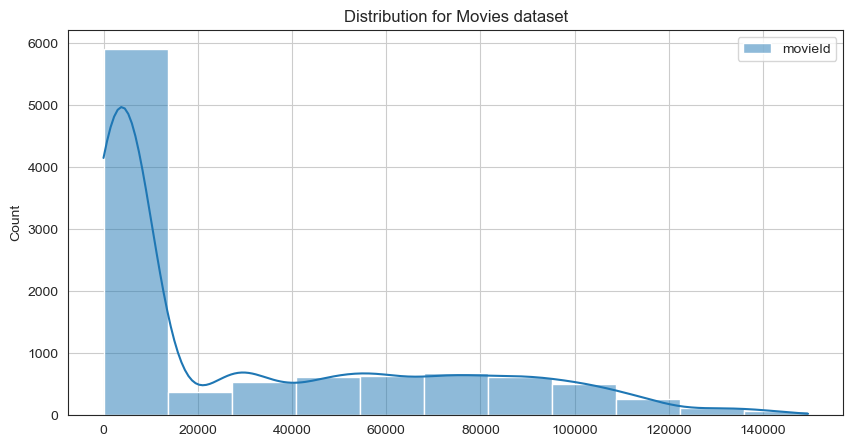

In [22]:
plt.title('Distribution for Movies dataset')
sns.histplot(data=movies,kde=True,bins = 11)
# plt.savefig("Distribution for Movies dataset.png")
plt.show()

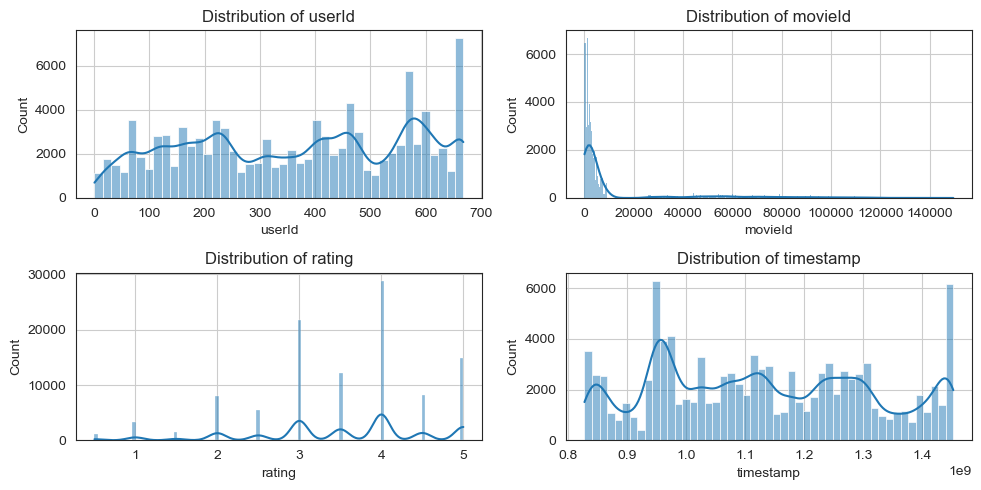

In [23]:
i=1
for j in ratings.columns:
    plt.subplot(2,2,i)
    plt.title('Distribution of {}'.format(j))
    sns.histplot(data=ratings,x=ratings[j],kde=True)
    i+=1
plt.tight_layout()
# plt.savefig("Distribution of Ratings dataset.png")
plt.show()

**Checking for outliers**

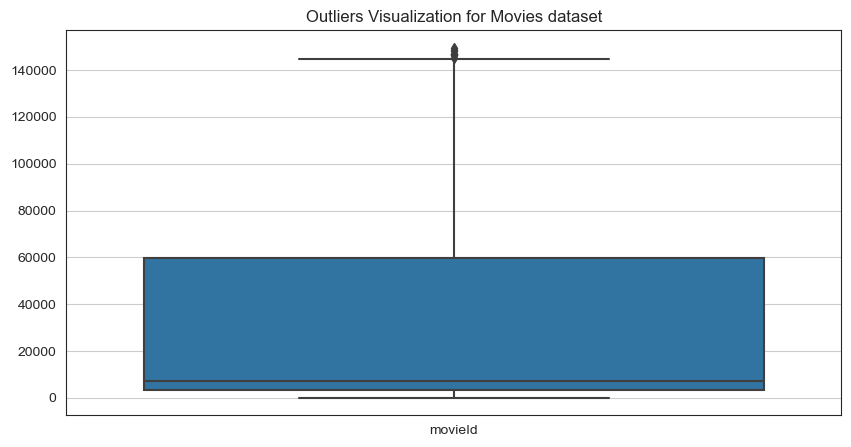

In [24]:
plt.title('Outliers Visualization for Movies dataset')
sns.boxplot(data = movies)
# plt.savefig('Outliers Visualization for Movies dataset.png')
plt.show()

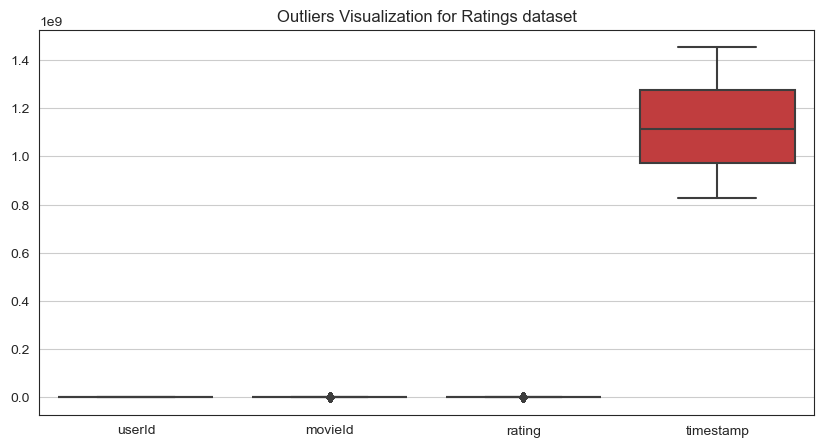

In [25]:
plt.title('Outliers Visualization for Ratings dataset')
sns.boxplot(data = ratings)
# plt.savefig('Outliers Visualization for Ratings dataset.png')
plt.show()

**Finding unique genres and movies per genre**

In [26]:
movie_title = []
movie_year = []

for title in movies['title']:
    movie_title.append(title[0:-7])
    movie_year.append(title[-5:-1])

In [27]:
genres = []

for genresPerMovie in movies['genres']:
    genresList = genresPerMovie.split('|')
    for genre in genresList:
        if genre not in genres:
            genres.append(genre)

genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'War',
 'Musical',
 'Documentary',
 'Western',
 'Film-Noir',
 '(no genres listed)']

In [28]:
genresCount = []

for genre in genres:
    count = 0
    for movieGenre in movies['genres']:
        if genre in movieGenre.split('|'):
            count +=1
    genresCount.append(count)

In [29]:
genresDF = pd.DataFrame({
    'Genres':genres,
    'Movies Count':genresCount
})
genresDF.sort_values(by="Movies Count",ascending=False, inplace=True)
genresDF.head()

,Genres,Movies Count
6,Drama,5219
3,Comedy,3515
9,Thriller,2187
5,Romance,1788
7,Action,1736


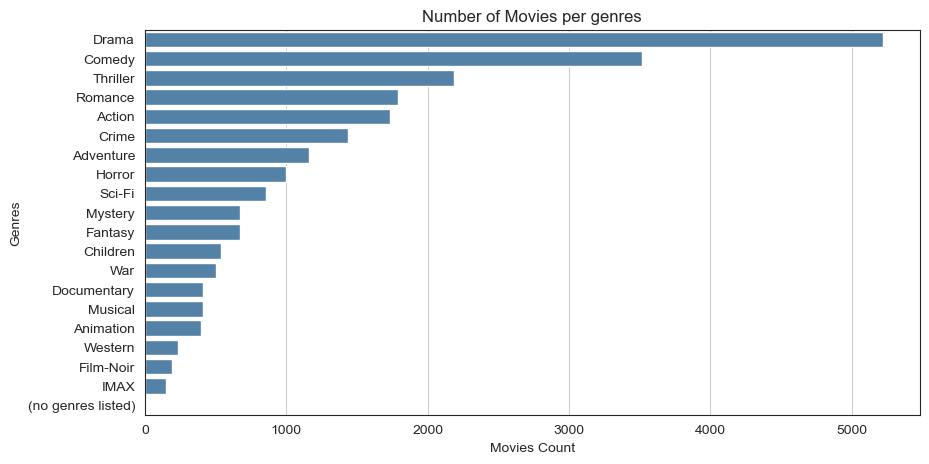

In [30]:
plt.title('Number of Movies per genres')
sns.barplot(data = genresDF, x = 'Movies Count', y = 'Genres', color = 'steelblue')
# plt.savefig('Number of Movies per genres.png')
plt.show()

**Merging 'movies' and 'ratings' dataset into moviesRatingsDF dataset**

In [31]:
moviesRatingDF = pd.merge(ratings, movies, how = 'left', on = 'movieId')
moviesRatingDF.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [32]:
moviesRatingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
 4   title      105334 non-null  object 
 5   genres     105334 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB


In [33]:
moviesRatingDF.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        5
genres       5
dtype: int64

In [34]:
moviesRatingDF[moviesRatingDF['title'].isnull()]

,userId,movieId,rating,timestamp,title,genres
66400,458,26982,4.0,1321471892,NaN,NaN
68133,461,64997,3.0,1264802172,NaN,NaN
74010,512,64997,2.5,1254434358,NaN,NaN
85181,575,64997,2.0,1231171245,NaN,NaN
102949,668,26982,3.0,1223578115,NaN,NaN


In [35]:
moviesRatingDF[moviesRatingDF['genres'].isnull()]

,userId,movieId,rating,timestamp,title,genres
66400,458,26982,4.0,1321471892,NaN,NaN
68133,461,64997,3.0,1264802172,NaN,NaN
74010,512,64997,2.5,1254434358,NaN,NaN
85181,575,64997,2.0,1231171245,NaN,NaN
102949,668,26982,3.0,1223578115,NaN,NaN


In [36]:
# Dropping null values from the movie dataset
moviesRatingDF.dropna(inplace=True)
moviesRatingDF.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [37]:
moviesRatingDF.describe()

,userId,movieId,rating,timestamp
count,105334.000000,105334.000000,105334.000000,1.053340e+05
mean,364.916475,13379.584180,3.516880,1.130418e+09
std,197.487373,26169.561127,1.044878,1.802680e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711007e+08
50%,383.000000,2496.000000,3.500000,1.115042e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


In [38]:
# Checking for duplicate rows in movieRatingDF dataset
moviesRating_dup = moviesRatingDF.duplicated()
if moviesRating_dup.any():
    print(f"{moviesRating_dup.sum()} duplicate(s) present in the movieRatingDF dataset:")
    print(ratings[moviesRating_dup])
else:
    print("No duplicates in the movieRatingDF dataset.")

No duplicates in the movieRatingDF dataset.


**Calculating 'Average Movie Rating', 'Total Ratings' & 'Num Reviews' for all movies**

In [39]:
movieRatings = pd.DataFrame(moviesRatingDF.groupby('title')[['rating']].mean())
movieRatings["Total Ratings"] = pd.DataFrame(moviesRatingDF.groupby('title')[['rating']].sum())
movieRatings["Num Reviews"] = pd.DataFrame(moviesRatingDF.groupby('title')[['rating']].count())
movieRatings.reset_index(drop = False, inplace= True)
movieRatings.rename(columns = {'title':'Movie Title','rating':'Average Movie Rating'}, inplace= True)
movieRatings.head()

,Movie Title,Average Movie Rating,Total Ratings,Num Reviews
0,'71 (2014),3.500,3.5,1
1,'Hellboy': The Seeds of Creation (2004),3.000,3.0,1
2,'Round Midnight (1986),2.500,2.5,1
3,'Til There Was You (1997),4.000,12.0,3
4,"'burbs, The (1989)",3.125,62.5,20


In [40]:
movieRatings.describe()

,Average Movie Rating,Total Ratings,Num Reviews
count,10323.000000,10323.000000,10323.000000
mean,3.177245,35.885595,10.203817
std,0.817556,87.370046,22.834300
min,0.500000,0.500000,1.000000
25%,2.750000,3.500000,1.000000
50%,3.272727,8.000000,3.000000
75%,3.750000,27.000000,8.000000
max,5.000000,1372.000000,325.000000


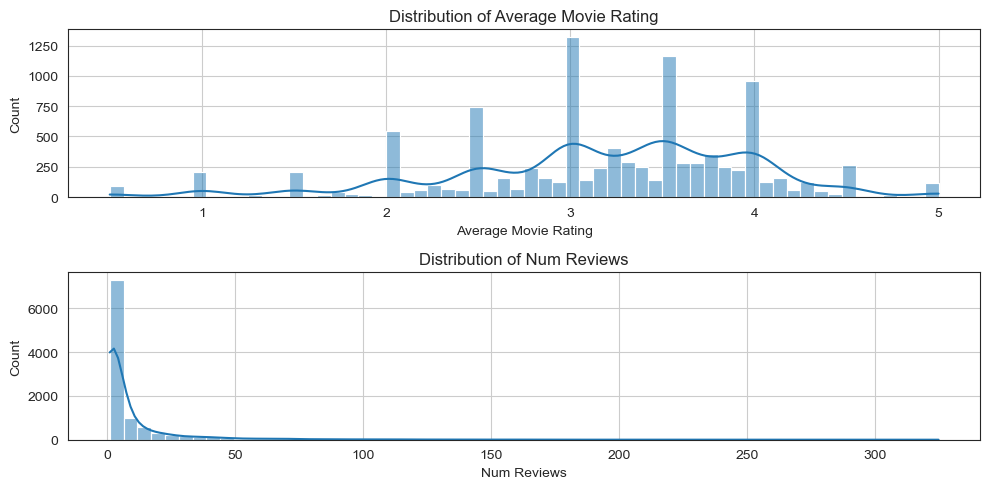

In [41]:
i=1
for j in movieRatings[['Average Movie Rating','Num Reviews']]:
    plt.subplot(2,1,i)
    plt.title('Distribution of {}'.format(j))
    sns.histplot(data=movieRatings,x=movieRatings[j],kde=True, bins = 60)
    i+=1
plt.tight_layout()
# plt.savefig('Distribution of Average Movie Rating & Number of Reviews.png')
plt.show()

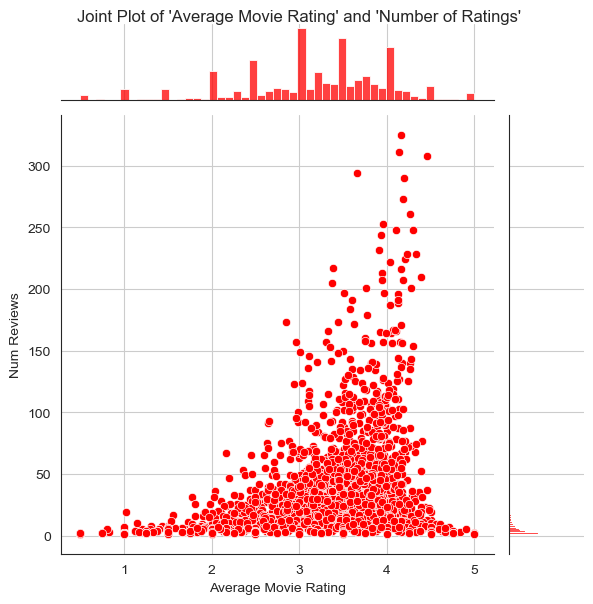

In [42]:
sns.jointplot(data = movieRatings, x = "Average Movie Rating", y="Num Reviews", kind = 'scatter',color = 'red')
plt.suptitle("Joint Plot of 'Average Movie Rating' and 'Number of Ratings'", y=1, fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Average Movie Rating',fontsize=10)
plt.ylabel('Num Reviews',fontsize=10)
# plt.savefig("Joint Plot of Average Movie Rating and Number of Ratings.png")
plt.show()

**Finding Top 20 movies based on 'Average Movie Rating', 'Total Ratings' & 'Number of Reviews' per movies respectively**

In [43]:
# Checking for Top 20 movies based on 'Average Movie Rating'
movieRatingsAvgTop20 = movieRatings.nlargest(20,'Average Movie Rating')
movieRatingsAvgTop20.head()

,Movie Title,Average Movie Rating,Total Ratings,Num Reviews
67,21 Up (1977),5.0,5.0,1
125,50 Children: The Rescue Mission of Mr. And Mrs...,5.0,5.0,1
283,Air (2015),5.0,5.0,1
488,Andrei Rublev (Andrey Rublyov) (1969),5.0,5.0,1
512,Animal Farm (1954),5.0,5.0,1


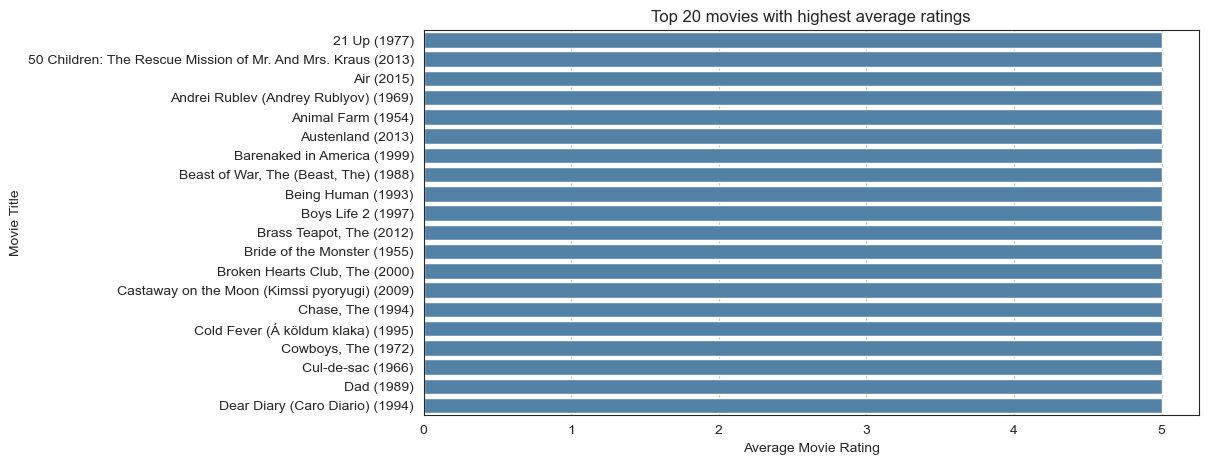

In [44]:
plt.title('Top 20 movies with highest average ratings')
sns.barplot(data = movieRatingsAvgTop20, y = 'Movie Title', x='Average Movie Rating', color='steelblue')
# plt.savefig('Top 20 movies with highest average ratings.png')
plt.show()

In [45]:
# Checking for Top 20 movies based on 'Total Ratings'
movieRatingsTotalTop20 = movieRatings.nlargest(20,'Total Ratings')
movieRatingsTotalTop20.head()

,Movie Title,Average Movie Rating,Total Ratings,Num Reviews
8136,"Shawshank Redemption, The (1994)",4.454545,1372.0,308
7323,Pulp Fiction (1994),4.160000,1352.0,325
3349,Forrest Gump (1994),4.138264,1287.0,311
8228,"Silence of the Lambs, The (1991)",4.194828,1216.5,290
8585,Star Wars: Episode IV - A New Hope (1977),4.188645,1143.5,273


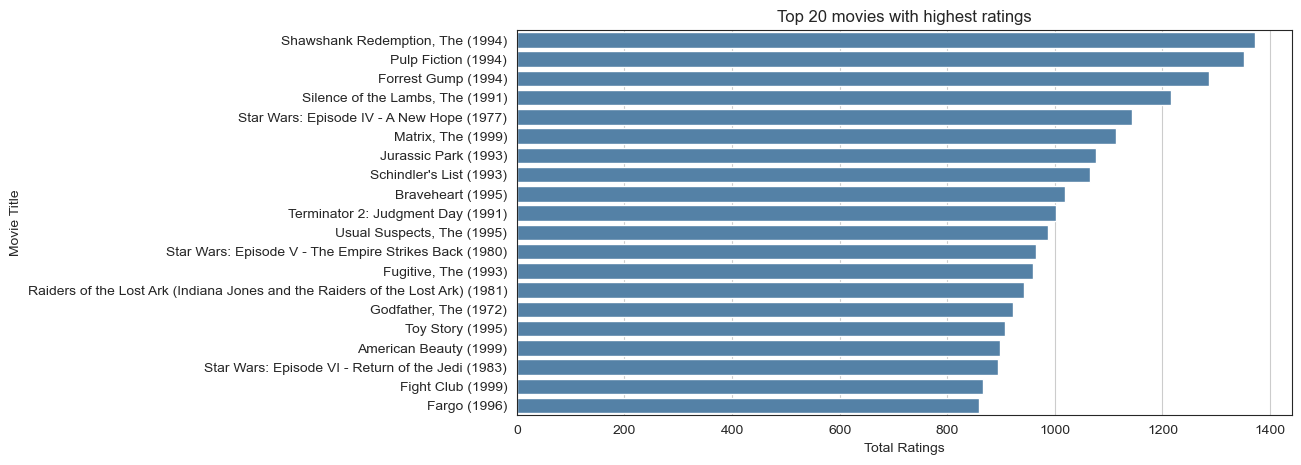

In [46]:
plt.title('Top 20 movies with highest ratings')
sns.barplot(data = movieRatingsTotalTop20, y = 'Movie Title', x='Total Ratings', color='steelblue')
# plt.savefig('Top 20 movies with highest ratings.png')
plt.show()

In [47]:
# Checking for Top 20 movies based on 'Number of Reviews'
movieRatingsCountTop20 = movieRatings.nlargest(20,'Num Reviews')
movieRatingsCountTop20.head()

,Movie Title,Average Movie Rating,Total Ratings,Num Reviews
7323,Pulp Fiction (1994),4.160000,1352.0,325
3349,Forrest Gump (1994),4.138264,1287.0,311
8136,"Shawshank Redemption, The (1994)",4.454545,1372.0,308
4934,Jurassic Park (1993),3.659864,1076.0,294
8228,"Silence of the Lambs, The (1991)",4.194828,1216.5,290


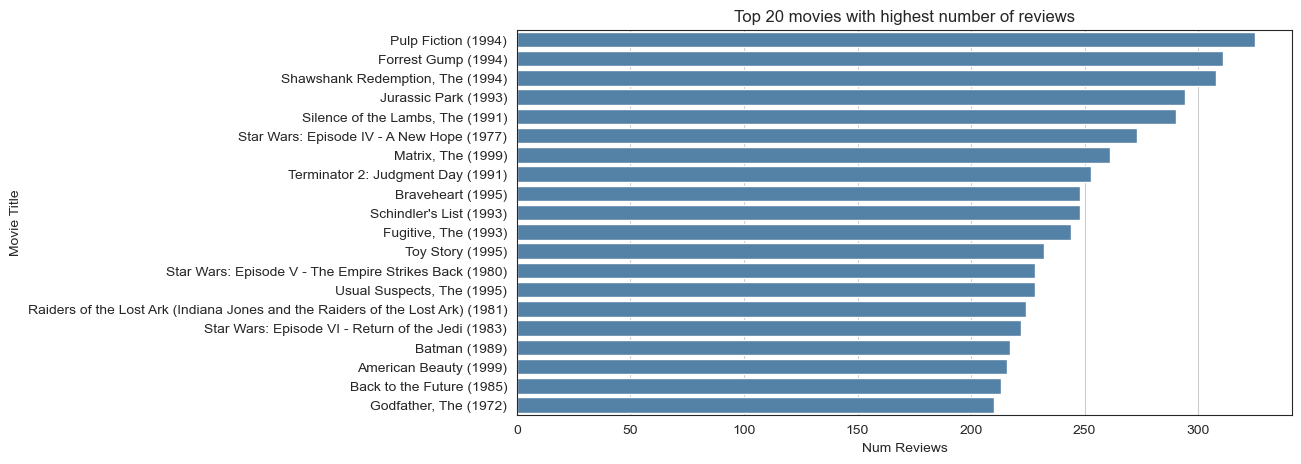

In [48]:
plt.title('Top 20 movies with highest number of reviews')
sns.barplot(data = movieRatingsCountTop20, y = 'Movie Title', x='Num Reviews', color='steelblue')
# plt.savefig('Top 20 movies with highest number of reviews.png')
plt.show()

## Types of recommendation system

1. **Popularity Based:** It keeps a track of view counts for each movie/video and then lists movies based on views in descending order.
2. **Content Based:** This type of recommendation systems, takes in a movie that a user currently likes as input. Then it analyzes the contents of the movie to find out other movies which have similar content. Then it ranks similar movies according to their similarity scores and recommends the most relevant movies to the user.
3. **Collaborative filtering:** In other words, the recommendations get filtered based on the collaboration between similar user’s preferences.

## Objective 1: Popularity Based Recommender System

Create a popularity based recommender system at a genre level. User will input a genre (g), minimum ratings threshold (t) for a movie and no. of recommendations(N) for which it should be recommended top N movies which are most popular within that genre (g) ordered by ratings in descending order where each movie has at least (t) reviews.

**Example:**

**Input:**

	Genre (g): Comedy
	Minimum reviews threshold (t): 100
	Num recommendations (N): 5

**Output** 

| Sl.No. | Movie Title | Average Movie Rating | Num Review |
| --- | --- | --- | --- |
| 1 | A | 4.5 | 422 |
| 2 | B | 4.4 | 482 |
| 3 | C | 4.3 | 245 |
| 4 | D | 4.22 | 541 |
| 5 | E | 4.21 | 420 |

--------------

To find movie recommendations based on genres, the following is required:

- Find the movies and their index values based on the genre
- Prepare a recommendation system which will show the 'Movie Title', 'Average Movie Rating' & 'Number of Reviews' per Movie

In [49]:
# Find the index value of movies based on the movie title with(out) years
def findMovieIndex(movieTitle):
    searchedMovieIndex = []
    for movie in movies['title']:

        # When only the movie title is mentioned without the released year
        if movieTitle == movie[:-7]:
            searchedMovieIndex = movies.index[movies['title'] == movie].tolist()

        # When only the movie title is mentioned with the released year
        elif movieTitle == movie:
            searchedMovieIndex = movies.index[movies['title'] == movie].tolist()
         
    return searchedMovieIndex[0]

In [50]:
# Find a movie and its index value which is of a specific genre
def findMoviesOnGenre(genre):
    
    # Creating a dictionary to store the index values & movie titles
    moviesOnGenre = {'Index':[],'Movie Title':[]}

    # Validating if the specified genre is available in the movie genres
    for movieGenre,movieTitle in zip(movies['genres'],movies['title']):
        
        if genre in movieGenre.split('|'):
            moviesOnGenre['Index'].append(findMovieIndex(movieTitle))
            moviesOnGenre['Movie Title'].append(movieTitle)
            
    # Creating a dataframe of movies with their index values
    moviesOnGenreDF = pd.DataFrame(data=moviesOnGenre)
    
    return moviesOnGenreDF

In [51]:
def popularityRecomendation(genre, nRecomendations, minReviewThreshold):
    
    # Prepare the dataset for all the movies of the specified genre, with 'Average Movie Rating' & 'Number of Reviews' per movie
    moviesRatingAtGenreDF = pd.merge(findMoviesOnGenre(genre),movieRatings, how = 'left', on = 'Movie Title').drop(columns = ["Total Ratings"]).set_index("Index")
    
    # Get n number of recommendation where no of reviews are more than the threshold value
    moviesRatingAtGenreDF = moviesRatingAtGenreDF[moviesRatingAtGenreDF['Num Reviews'] >= minReviewThreshold].nlargest(nRecomendations,'Average Movie Rating')
    moviesRatingAtGenreDF.index = np.arange(1,len(moviesRatingAtGenreDF)+1)

    return moviesRatingAtGenreDF

In [52]:
popularityRecomendation(genre = "Comedy", nRecomendations = 5, minReviewThreshold = 100)

,Movie Title,Average Movie Rating,Num Reviews
1,Monty Python and the Holy Grail (1975),4.301948,154.0
2,Fargo (1996),4.271144,201.0
3,"Princess Bride, The (1987)",4.163743,171.0
4,Pulp Fiction (1994),4.160000,325.0
5,Forrest Gump (1994),4.138264,311.0


## Objective 2: Content Based Recommender System

Create a content based recommender system which recommends top N movies based on similar movie(m) genres.

**Example:**

**Input:**

	Movie Title (t): Toy Story
	Num recommendations (N): 5

**Output** 

| Sl.No. | Movie Title |
| --- | --- |
| 1 | A |
| 2 | B |
| 3 | C |
| 4 | D |
| 5 | E |

-------

In [53]:
def contentRecommendation(movieTitle, nRecommendation):
    if movieTitle == np.nan:
        return pd.Dataframe(data={'title':[]})
    movie_index = findMovieIndex(movieTitle)

    # Extract all genres 
    genres = movies['genres']

    # Initialize CountVectorizer to convert text data into token counts
    cv = CountVectorizer()
    genre_matrix = cv.fit_transform(genres)

    # Calculate cosine similarity between the input movie and all other movies
    sim_scores = cosine_similarity(genre_matrix, genre_matrix[movie_index])

    # Enumerate through similarity scores and keep track of movie indices
    movie_indices_scores = pd.DataFrame(enumerate(sim_scores),columns = ['index','sim_score'])
    movie_indices_scores['sim_score'] = [i[0] for i in movie_indices_scores['sim_score']]

    # Create a movie list with sim_score added to the table
    moviesList = pd.merge(movies.iloc[movie_indices_scores['index']].reset_index(),movie_indices_scores, how = 'left', on = 'index').set_index('index')
    
    # Get Top n Recommendation 
    topNRecommendedMovies = moviesList[moviesList['genres']==moviesList.iloc[movie_index]['genres']].drop(index = movie_index).nlargest(nRecommendation,'sim_score')
    topNRecommendedMovies.index = np.arange(1,len(topNRecommendedMovies)+1)
    
    return topNRecommendedMovies[["title"]]

In [54]:
contentRecommendation(movieTitle = 'Toy Story (1995)', nRecommendation = 5)

,title
1,Antz (1998)
2,Toy Story 2 (1999)
3,"Adventures of Rocky and Bullwinkle, The (2000)"
4,"Emperor's New Groove, The (2000)"
5,"Monsters, Inc. (2001)"


In [55]:
contentRecommendation(movieTitle = 'Monsters, Inc.', nRecommendation = 5)

,title
1,Toy Story (1995)
2,Antz (1998)
3,Toy Story 2 (1999)
4,"Adventures of Rocky and Bullwinkle, The (2000)"
5,"Emperor's New Groove, The (2000)"


## Objective 3: Collaborative Based Recommender System

Create a collaborative based recommender system which recommends top N
movies based on “K” similar users for a target user “u”

**Example:**

**Input:**

	UserID: 1
	Num recommendations(N) : 5
	Threshold for similar users (k): 100

 **Output** 

| Sl.No. | Movie Title |
| --- | --- |
| 1 | A |
| 2 | B |
| 3 | C |
| 4 | D |
| 5 | E |

-------

**Create a pivot table for movieRatingDF**

In [56]:
pivot_movie = moviesRatingDF.pivot_table(index ='userId',columns ='title', values ='rating') .fillna(0)
pivot_movie

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 (1979),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),a/k/a Tommy Chong (2005),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0


In [57]:
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model.fit(pivot_movie)

NearestNeighbors(algorithm='brute', metric='cosine')

In [58]:
def collaborativeRecommendation(userId, nRecommendations, kSim_users):
    # Find the index of the target user
    target_user_index = pivot_movie.index.get_loc(userId)

    # Setting nNeighbour default to kSim_users
    nNeighbour = kSim_users

    #  Modify nNeighbour to odd for all scenarios
    if kSim_users % 2 == 0:
        nNeighbour = kSim_users+1

    # Use kneighbors to find K similar users
    _, similarUserIndices = knn_model.kneighbors(pivot_movie.iloc[target_user_index].values.reshape(1, -1), n_neighbors=nNeighbour)

    # Flatten the list of similar users indices
    similarUserIndices = similarUserIndices.flatten()

    # Get movies already watched by the target user
    moviesWatched = pivot_movie.iloc[target_user_index][pivot_movie.iloc[target_user_index] > 0].index.tolist()

    # Create a list of movies recommended by similar users, which specified user is yet to watch
    moviesRecommended = []
    for similarUserIndex in similarUserIndices:
        similarUserMovies = pivot_movie.iloc[similarUserIndex][pivot_movie.iloc[similarUserIndex] > 0].index.tolist()
        moviesRecommended.extend([movie for movie in similarUserMovies if movie not in moviesWatched])

    # Get top N recommendations based on similar user watched list
    moviesRecommended = list(set(moviesRecommended))[:nRecommendations]

    # Create movieRecommended Dataset
    moviesRecommendedDF = pd.DataFrame(data = {'title': moviesRecommended}, index = np.arange(1,len(moviesRecommended)+1))

    return moviesRecommendedDF

In [59]:
user_id_input = 1
num_recommendations_input = 5
k_input = 100
collaborativeRecommendation(userId=user_id_input, nRecommendations=num_recommendations_input, kSim_users=k_input)

,title
1,"40-Year-Old Virgin, The (2005)"
2,"Sandlot, The (1993)"
3,"Thomas Crown Affair, The (1968)"
4,"Fly, The (1958)"
5,"Last Supper, The (1995)"


## Prepare movie recommendation widgets using ipywidgets library 

### 1. Popularity Based Movie Recommender

In [60]:
# Creating widgets for Popularity Recommender
movieGenre_input = wdg.Text(description='Genre (g):')
reviewThreshold = wdg.Label("Minimum reviews threshold (t):")
reviewThreshold_input = wdg.IntSlider(min = 1, max = 325, value = 100)
nRec = wdg.Label("Num recommendations (N):")
nRecomendations_input = wdg.IntSlider(min = 1, max = 30, value = 5)
btn = wdg.Button(description = "Recommend Movies")
out = wdg.Output(layout={'border': '1px solid black'})
print("Search out of the following genres:\n", genres[:-1])
print("---------------------------"*5)
display(movieGenre_input,reviewThreshold,reviewThreshold_input,nRec,nRecomendations_input,btn)

def popularityRecommender(b):
    out.clear_output()
    df = popularityRecomendation(genre = movieGenre_input.value, 
                                 nRecomendations = nRecomendations_input.value, 
                                 minReviewThreshold = reviewThreshold_input.value)
    with out:
        if len(df) != 0:
            display(df)
        else:
            display("No movies found to recommend.")

btn.on_click(popularityRecommender)
display(out)


Search out of the following genres:
 ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir']
---------------------------------------------------------------------------------------------------------------------------------------


Text(value='', description='Genre (g):')

Label(value='Minimum reviews threshold (t):')

IntSlider(value=100, max=325, min=1)

Label(value='Num recommendations (N):')

IntSlider(value=5, max=30, min=1)

Button(description='Recommend Movies', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

### 2. Content Based Movie Recommender

In [61]:
# Creating widgets for Content Recommender
movieTitle_input = wdg.Text(description='Movie Title (t):')
recNum = wdg.Label("Num recommendations (N):")
nRecomendations_input = wdg.IntSlider(min = 1, max = 30, value = 5)
btn = wdg.Button(description = "Recommend Movies")
out = wdg.Output(layout={'border': '1px solid black'})
display(movieTitle_input,recNum,nRecomendations_input,btn)

def contentRecommender(b):
    out.clear_output()
    with out:
        if len(movieTitle_input.value)==0:
            display("No movies found to recommend.")
        else:
            try:
                df = contentRecommendation(movieTitle = movieTitle_input.value, 
                               nRecommendation = nRecomendations_input.value)
                if len(df) == 0:
                    display("No movies found to recommend.")
                else:
                    display(df)
            except(KeyError):
                display("No movies found to recommend.")

btn.on_click(contentRecommender)
display(out)


Text(value='', description='Movie Title (t):')

Label(value='Num recommendations (N):')

IntSlider(value=5, max=30, min=1)

Button(description='Recommend Movies', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

### 3. Collaboration Based Movie Recommender

In [62]:
# Creating widgets for Collaboration Recommender
user_id_input = wdg.IntSlider(min = 1, max = 668, value = 1, description ='UserId:')
l1 = wdg.Label("Num recommendations (N):")
num_recommendations_input = wdg.IntSlider(min = 1, max = 30, value = 5)
l2 = wdg.Label("Threshold for similar users (k):")
k_input = wdg.IntSlider(min = 50, max = 668, value = 100)
btn = wdg.Button(description = "Recommend Movies")
out = wdg.Output(layout={'border': '1px solid black'})
display(user_id_input,l1,num_recommendations_input,l2,k_input,btn)

def collaborativeRecommeder(b):
    out.clear_output()
    df = collaborativeRecommendation(userId = user_id_input.value, 
                                     nRecommendations = num_recommendations_input.value, 
                                     kSim_users=k_input.value)
    with out:
        if len(df) != 0:
            display(df)
        else:
            print("No movies found to recommend.")

btn.on_click(collaborativeRecommeder)
display(out)


IntSlider(value=1, description='UserId:', max=668, min=1)

Label(value='Num recommendations (N):')

IntSlider(value=5, max=30, min=1)

Label(value='Threshold for similar users (k):')

IntSlider(value=100, max=668, min=50)

Button(description='Recommend Movies', style=ButtonStyle())

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…